In [1]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from torchvision import transforms

from trainer import fit
import numpy as np

cuda = torch.cuda.is_available()

In [2]:
# Set up data loaders
from datasets import ImageFolderDataset
from datasets import BalancedBatchSampler

import csv
import json

root_dir = '../AIC20_ReID/image_train'
train_csv = 'metadata/cls_train.csv'
val_csv = 'metadata/cls_val.csv'
label_json = 'metadata/train_image_metadata.json'

size = (224, 224)

def get_images_labels(vehicle_csv, label_json):
    with open(label_json, 'r') as json_file:
        data_dict = json.load(json_file)
    image_names = []
    labels = []
    with open(vehicle_csv, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        header = next(csv_reader)
        for row in csv_reader:
            vehicle_id = row[0]
            for cam_id in data_dict[vehicle_id]:
                image_names += [image_name for image_name in data_dict[vehicle_id][cam_id]]
                labels += [int(vehicle_id) for image_name in data_dict[vehicle_id][cam_id]]
    return image_names, labels

train_image_names, train_labels = get_images_labels(train_csv, label_json) 
val_image_names, val_labels = get_images_labels(val_csv, label_json) 

train_dataset = ImageFolderDataset(root_dir, train_image_names, train_labels,
                                       transform = transforms.Compose([
                                        transforms.Resize(size),  
                                        transforms.ToTensor()
                                      ]))
val_dataset = ImageFolderDataset(root_dir, val_image_names, val_labels,
                                     transform = transforms.Compose([
                                        transforms.Resize(size),
                                        transforms.ToTensor()
                                      ]))



train_batch_sampler = BalancedBatchSampler(train_dataset.labels, n_classes=5, n_samples=5)
val_batch_sampler = BalancedBatchSampler(val_dataset.labels, n_classes=5, n_samples=5)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_val_loader = torch.utils.data.DataLoader(val_dataset, batch_sampler=val_batch_sampler, **kwargs)

In [ ]:
PATH = 'weights/onlinetriplet-b4-200405-hardest_30epochs.pth'
model = torch.load(PATH)

In [4]:
import random

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

num_classes = 333
r = lambda: random.randint(0,255)

classes = set(train_dataset.labels + val_dataset.labels)
colors = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(num_classes)]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    print("PLOTTING")
    plt.figure(figsize=(10,10))
    tsne_model = TSNE(n_components=2)
    tsne_embeddings = tsne_model.fit_transform(embeddings)
    
    for i, _class in enumerate(classes):
        inds = np.where(targets==_class)[0]
        plt.scatter(tsne_embeddings[inds,0], tsne_embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes, bbox_to_anchor=(1.02, 1), loc="upper left", ncol=10)
    
def extract_embeddings(dataloader, model):
    print("EXTRACTING")
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 1792))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

EXTRACTING
PLOTTING


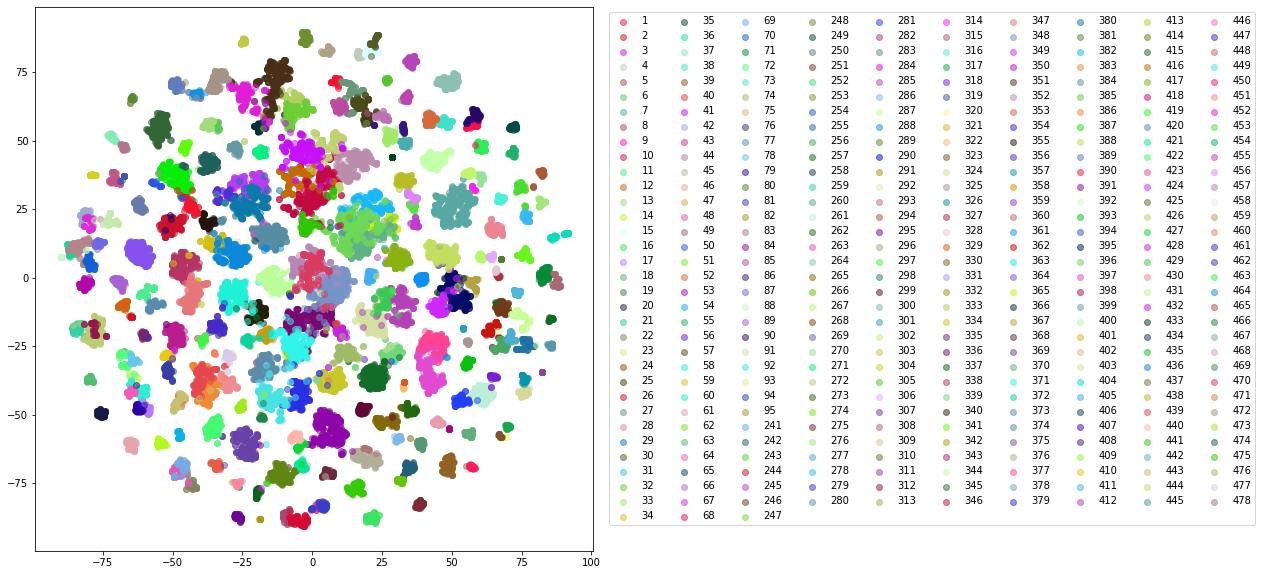

In [5]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)

EXTRACTING
PLOTTING


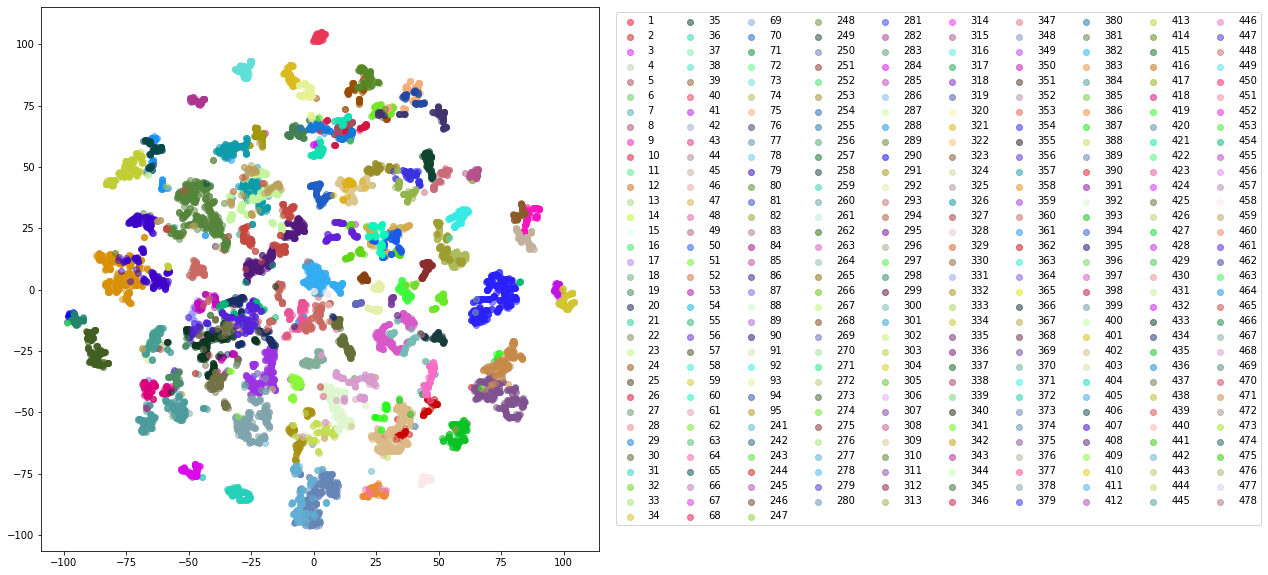

In [6]:
val_embeddings_tl, val_labels_tl = extract_embeddings(val_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)